# TP8: Approximation des valeurs propres du Laplacien #

## 1. Formulation par éléments finis ## 

$$
\newcommand{\sca}[2]{\langle #1\mid #2 \rangle}
\newcommand{\LL}{\mathrm{L}} 
\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\Psp}{\mathbb{P}}
$$
On s'intéresse à la recherche des valeurs propres du laplacien avec conditions de Neumann d'un ouvert $\Omega\subseteq \Rsp^2$ par la méthode des éléments finis en 2D. On part d'une triangulation $T_h$ de $\Omega$, et on note:
* $V_h$ l'espace kdes éléments finis $\Psp_1$ sur $T_h$, de sorte que $V_h\subseteq V := H^1(\Omega)$;
* $N_h :=\dim(V_h) = N_h$;
* $H := \LL^2(\Omega) $ ;

Il s'agit alors de trouver $\lambda_{1,h}\leq \dots \lambda_{N_h,h} \in \Rsp$ et $w_{1,h},\dots,w_{N_h,h}$ une base orthonormée de $V_h$ telle que 

$$
\forall m\in\{1,\dots,N_h\},~\forall v_h\in V_h,\qquad a(w_{m,h}, v_h) = \lambda_{m,h} \sca{w_{m,h}}{v_h} 
$$

où $a(u,v) = \int_{\Omega} \sca{\nabla u}{\nabla v} + uv$.

Pour tout noeud $x_i$ (= sommet de la triangulation), on note $\phi_i$ la fonction chapeau correspondante, i.e. la fonction $\phi_i\in V_h$ telle que $\phi_i(x_j) = \delta_{i,j}$.

**Q1.** Montrer que $\lambda\in \Rsp$ et $w = \sum_{i} W_i \phi_i\neq 0$ est un couple de valeur/vecteur propre pour le problème variationnel  si et seulement si 

$$ (K+M) W = \lambda M W$$

où les matrice $K$ et $M$ sont à préciser.

**Q2.** On suppose donnée une matrice $D_x$ de taille $NT_h\times N_h$ où $NT_h$ est le nombre de triangles, et telle que si $u = \sum_i U_i \phi_i$, alors $(D_x U)_j = \left.\partial_x u\right|_{\sigma_j}$ où $\sigma_j$ est le $j$ième simplexe. En d'autre terme, $D_x U$ calcule la liste des dérivées partielles par rapport à $x$ de $u$ sur chaque triangle. Une seconde matrice $D_y$ est définie de même, et on note $A = (\mathrm{aire}(\sigma_j))_{1\leq j\leq NT_h}$. Donner une expression simple de $K$ en fonction de $D_x, D_y$ et $\mathrm{diag}(A)$.

**Q3.** Montrer que la matrice $M$ n'est jamais diagonale dès que $T_h$ comporte plus d'un triangle.

On va approcher le problème de calcul de valeurs propres en remplaçant $M_{ij} = \int_{\Omega} \phi_i\phi_j$ en utilisant la formule de quadrature suivante, pour un triangle $\sigma$ de sommets $A,B,C$
$$ I_\sigma(f) := \int_\sigma f \simeq \frac{\mathrm{aire}(\sigma)}{3}(f(A) + f(B) + f(C)).$$

**Q4.** On définit une matrice de masse condensée (on parle de *mass lumping* en anglais) par

$$\tilde{M}_{ij} = \sum_{\sigma\in T_h} I_\sigma(\psi_i\psi_j). $$

Montrer que $\tilde{M}$ est diagonale inversible et calculer ses coefficients.

**Q5.** Construire explicitement une matrice symétrique $Z$ (dépendant de $K$ et $\tilde{M}$) telle que

$$ \exists W\neq 0 \hbox{ t.q. } (K+\tilde M) W = \lambda \tilde{M} W \Longleftrightarrow \lambda \hbox{ est valeur propre de } Z $$

**Q6.** Construire les matrices $K$, $\tilde{M}$ et $Z$ en Python, et calculer les 10 premières valeurs propres dans le cas $\Omega = [0,1]^2$ et $h=1/30$. Pour le calcul des k plus petites valeurs propres de $Z$, on utilisera l'instruction
*splinalg.eigsh(Z,k,sigma=0)* 

(NB: splinalg est le package d'algèbre linéaire sparse (creuse), eigsh est la fonction de calcul des valeurs propres pour des matrices hermitiennes (h))



valeurs propre 1: 10.859


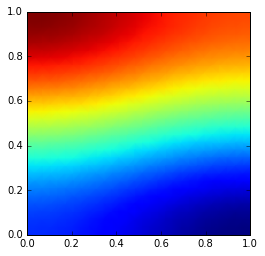

valeurs propre 2: 10.859


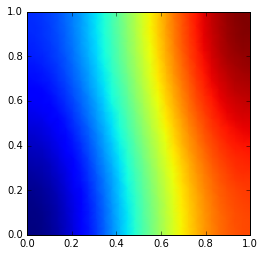

valeurs propre 3: 20.7154


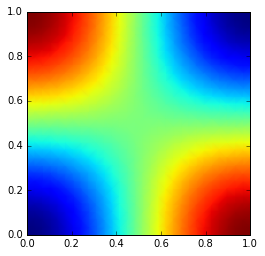

valeurs propre 4: 40.3069


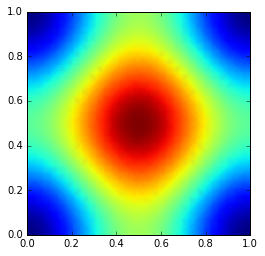

valeurs propre 5: 40.3108


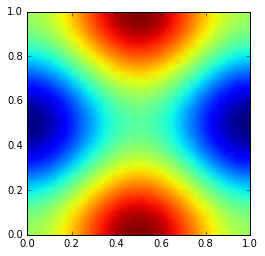

valeurs propre 6: 50.1502


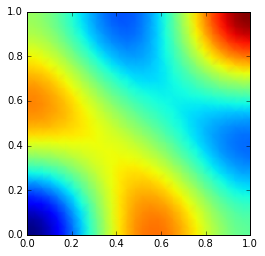

valeurs propre 7: 50.1622


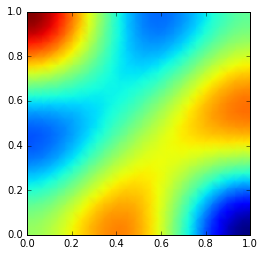

valeurs propre 8: 79.5906


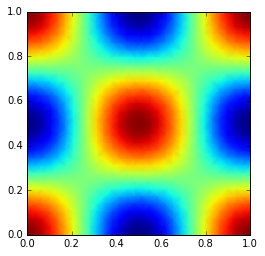

valeurs propre 9: 88.9651


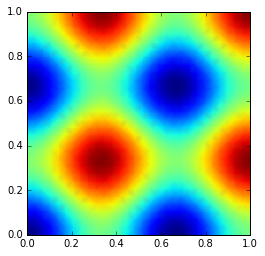

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

# calcule la normale d'une famille de triangles triangle 3D, en déduit le gradient des fonctions dont 
# les triangles sont le graphe
def tri_gradient(A,B,C):
    N = np.cross(B - A, C-B)
    Gx = -N[:,0] / N[:,2]
    Gy = -N[:,1] / N[:,2]
    return Gx, Gy

# calcule les matrices Dx, Dy et A 
# NB: on utilise le package scipy.sparse pour un stockage "creux" des matrices,
# c'est-à-dire qu'on ne stocke que les entrées non nulles de la matrice.
def derivees_et_aires(X,T):
    nt = T.shape[0];
    npts = X.shape[0];
  
    A = X[T[:,0],:]; # liste des points A des triangles
    B = X[T[:,1],:]; # liste des points B des triangles
    C = X[T[:,2],:]; # liste des points C des triangles
  
    # calcul de dx et dy sur chaque triangle, en fonction de la valeur de
    # la fonction aux sommets du triangle
    Z = np.zeros((nt,1));
    I = np.ones((nt,1));
    [Gx1,Gy1] = tri_gradient(np.hstack((A,I)),np.hstack((B,Z)),np.hstack((C,Z)));
    [Gx2,Gy2] = tri_gradient(np.hstack((A,Z)),np.hstack((B,I)),np.hstack((C,Z)));
    [Gx3,Gy3] = tri_gradient(np.hstack((A,Z)),np.hstack((B,Z)),np.hstack((C,I)));
  
    # assemblage des matrices creuses
    # pour chaque triangle 1\leq t \leq nt, on a trois coefficients non nuls
    # en (t,a), (t,b), (t,c) où a = T[i,1], b=T[i,2], c=T[i,3]
    I = np.hstack((np.arange(nt), np.arange(nt), np.arange(nt)))
    J = np.hstack((T[:,0], T[:,1], T[:,2]))
    Sx = np.hstack((Gx1,Gx2,Gx3))
    Sy = np.hstack((Gy1,Gy2,Gy3))
    
    # les matrices creuses sont construites de la manière suivante:
    # pour tout l dans 0, ..., len(J)-1, on pose dx[I[k],J[k]] = Sx[k]
    dx = sp.csc_matrix((Sx,(I,J)),shape=(nt,npts))
    dy = sp.csc_matrix((Sy,(I,J)),shape=(nt,npts))
    
    # calcul de l'aire des triangles:
    AB = B-A
    BC = C-B
    aires = .5*(AB[:,0]*BC[:,1] - AB[:,1]*BC[:,0])
    return dx, dy, aires

# construction de la triangulation et des matrices Dx, Dy et vecteur A des aires
def triangulation_carre(n):
    x,y = np.meshgrid(np.linspace(0.,1.,n),
                      np.linspace(0.,1.,n))
    x = x.reshape(n*n,1)
    y = y.reshape(n*n,1)
    X = np.hstack((x,y))
    T = tri.Triangulation(x.flatten(), y.flatten()).triangles
    return X,T

X,T = triangulation_carre(30)
[Dx,Dy,aires] = derivees_et_aires(X,T)

# assemblage de la matrice de masse condensée
C = np.zeros(X.shape[0])
for i in xrange(T.shape[0]):
    C[T[i,0]] += aires[i] / 3.0
    C[T[i,1]] += aires[i] / 3.0
    C[T[i,2]] += aires[i] / 3.0
M = sp.diags(C)

# assemblage de la matrice de rigidité
A = sp.diags(aires)
K = Dx.T*A*Dx + Dy.T*A*Dy

# sysème équivalent
L = sp.diags(np.sqrt(C))
Linv = sp.diags(1./np.sqrt(C))
Z = Linv * (K+M) * Linv

nvp=10
[w,psi] = splinalg.eigsh(Z,nvp,sigma=0)
for i in xrange(1,nvp):
    print "valeurs propre %d: %g" % (i, w[i])
    v = Linv.dot(psi[:,i])
    plt.tripcolor(X[:,0],X[:,1],T,v,shading='gouraud')
    plt.gca().set_aspect('equal')
    plt.show()
    
    


**Q7.** Refaire les mêmes calculs dans le cas d'une couronne triangulée.

In [7]:
# Créer la triangulation d'une couronne
def triangulation_couronne(nrad=8,nang=36):
    radii = np.linspace(0.25, 1, nrad)
    angles = np.linspace(0, 2*np.pi, nang, endpoint=False)
    angles = np.repeat(angles[..., np.newaxis], nrad, axis=1)
    angles[:, 1::2] += np.pi/nang
    npts = len(radii)*len(angles)
    x = (radii*np.cos(angles)).flatten()
    y = (radii*np.sin(angles)).flatten()

    # On construit une triangulation de Delaunay et on filtre les triangles proches de l'origine
    triang = tri.Triangulation(x, y)
    xmid = x[triang.triangles].mean(axis=1)
    ymid = y[triang.triangles].mean(axis=1)
    mask = xmid*xmid + ymid*ymid >= .25*.25
    T = triang.triangles[mask,:]
    X = np.hstack((x.reshape(npts,1), y.reshape(npts,1)))
    return X,T

# à compléter

## 2. Recherche de valeurs propres ## 

**Q8.** Soit $Z$ une matrice symétrique de taille $N$, $\lambda_1,\dots, \lambda_N$ ses valeurs propres et $w_1,\dots,w_N$ une base orthonormale de vecteurs propres de $\Rsp^N$. On suppose que pour tout $i\neq N$, $|\lambda_{i}| < |\lambda_N|$. Soit $x_0 \in \Rsp^N$ tel que $\sca{x_0}{w_N} \neq 0$ et $x_{k+1} = A x_k / \|A x_k\|$. Démontrer que

$$ \min_{\varepsilon \in \{\pm 1\}} \left\|x_{k+1} - \varepsilon w_N\right\| \leq C(x_0) \lambda_{N-1}. $$

En déduire que $\lim_{k\to\infty} \|A x_k\| = |\lambda_N|$.

Pourquoi la méthode fonctionne-t'elle avec probabilité $1$ si $x_0$ est tiré aléatoirement selon une loi Gaussienne (par exemple) ?

**Q9.** Ici, nous souhaitons trouver la plus *petite* valeur propre. Soit encore $Z$ symétrique réelle et $\sigma \not\in \{\lambda_1,\dots,\lambda_N\}$. Pour $x_0 \in \Rsp^N$ on pose

$$ x_{k+1} = (Z - \sigma I_N)^{-1} x_k $$

On suppose qu'il existe $i_0 \in \{1,\dots,N\}$ tel que $\forall i\neq i_0$, $|\lambda_i - \sigma| < |\lambda_{i_0} - \sigma|$. Démontrer que si $\sca{x_0}{w_{i_0}} \neq 0$ alors 

$$ \lim_{N\to\infty} x_i = \pm w_{i_0}. $$

Cette méthode est appelée méthode de la puissance inverse.

**Q10.** Programmer la méthode de la puissance inverse, et la tester pour trouver le quatrième vecteur propre du laplacien de Neumann pour le carré en choisissant $\sigma$ une approximation numérique de $\lambda_4$. On utilisera *splinalg.spsolve* pour résoudre les systèmes linéaires creux (et *sp.eye* pour construire la matrice identité creuse)

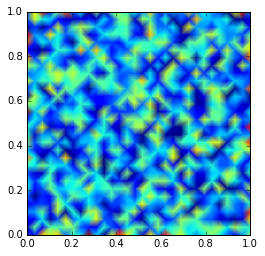

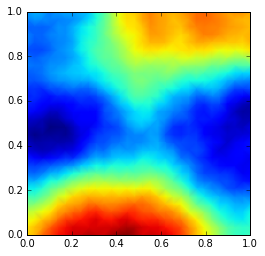

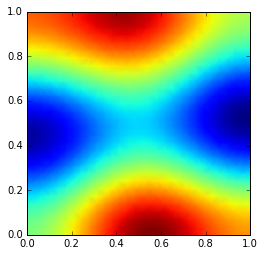

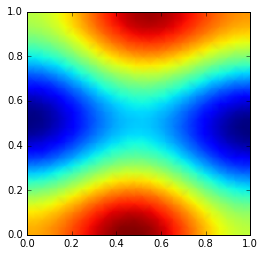

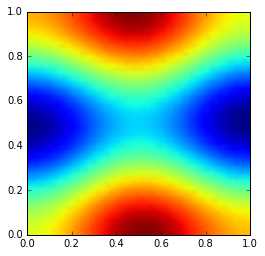

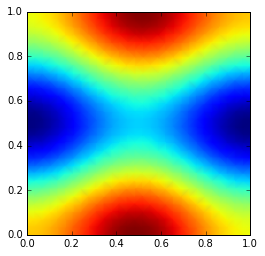

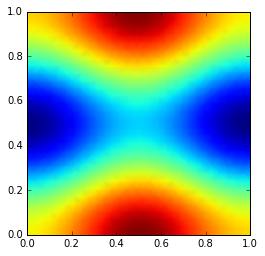

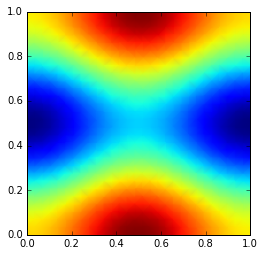

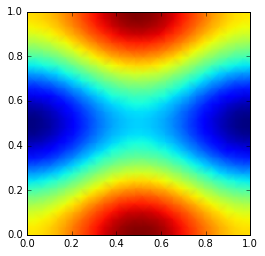

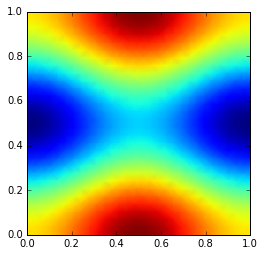

In [17]:
N = X.shape[0]
I = sp.eye(N)
psi = np.random.rand(N)
sigma = 20.0
for i in xrange(10):
    psi = splinalg.spsolve(Z - sigma*I, psi)
    psi = psi / np.linalg.norm(psi)
v = Linv.dot(psi)
plt.tripcolor(X[:,0],X[:,1],T,v,shading='gouraud')
plt.gca().set_aspect('equal')
plt.show()